# <center><font color='Blue'>**Assignment 1**</font></center>
<center> Author: Enkhsaikhan Usny-Ekh

Executive summary of the analysis

This analysis explores the relationship between car price and age for used cars in Chicago. Total of 5 models are estimated and heteroscedasticity robust standard errors are used: Level-Level, Log-Level, Log-Log, Polynomial, Piecewise Spline. Among these, the Log-Level model is chosen for its simplicity, interpretibility. 

The analysis finds a negative association: the price is lower, on average, by 11.2% for every additional year of age. An external validation using data from Los Angeles supports the fining from Chicago, highlighting the robustness of the Log-Level model.

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import haversine as hs   
from haversine import Unit
import os
from skimpy import skim


warnings.filterwarnings("ignore")

##### Importing data

In [4]:
df_cars = pd.read_csv('../data/used-cars.csv')

In [5]:
df_cars["lprice"] = np.log(df_cars["price"])
df_cars["lage"] = np.log(df_cars["age"])
df_cars["agesq"] = np.sqrt(df_cars["age"])

In [6]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pricestr      549 non-null    object 
 1   area          549 non-null    object 
 2   subarea       540 non-null    object 
 3   name          549 non-null    object 
 4   condition     327 non-null    object 
 5   cylinders     360 non-null    object 
 6   drive         294 non-null    object 
 7   fuel          548 non-null    object 
 8   odometer      549 non-null    float64
 9   paintcolor    316 non-null    object 
 10  size          193 non-null    object 
 11  transmission  549 non-null    object 
 12  type          301 non-null    object 
 13  dealer        549 non-null    int64  
 14  price         549 non-null    int64  
 15  lnprice       549 non-null    float64
 16  year          549 non-null    int64  
 17  age           549 non-null    int64  
 18  lnodometer    549 non-null    

### Spliting data set by areas

In [7]:
df_chicago = df_cars[df_cars["area"] == "chicago"]
df_langels = df_cars[df_cars["area"] == "los angeles"]

In [8]:
df_chicago = df_chicago.sort_values(by="age")
df_langels = df_langels.sort_values(by="age")

In [9]:
df_chicago 

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,year,age,lnodometer,LE,XLE,SE,Hybrid,lprice,lage,agesq
87,$16900,chicago,indiana NW,2017 Toyota Camry SE,NaN,NaN,NaN,gas,1.872817,NaN,...,2017,1,0.627444,0,0,1,0,9.735069,0.000000,1.000000
180,$16499,chicago,chicago city,2017 TOYOTA CAMRY,NaN,NaN,fwd,gas,2.943900,black,...,2017,1,1.079735,0,0,0,0,9.711055,0.000000,1.000000
108,$18495,chicago,chicago S,2017 toyota camry,excellent,4 cylinders,4wd,gas,0.231900,NaN,...,2017,1,-1.461449,0,0,0,0,9.825256,0.000000,1.000000
284,$15995,chicago,chicago city,2017 TOYOTA CAMRY,NaN,NaN,fwd,gas,5.491100,silver,...,2017,1,1.703129,0,0,0,0,9.680031,0.000000,1.000000
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.315200,NaN,...,2016,2,0.273989,0,0,0,0,9.656947,0.693147,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,$1300,chicago,chicago W,1993 toyota camry,good,6 cylinders,fwd,gas,15.100000,NaN,...,1993,25,2.714695,0,0,0,0,7.170120,3.218876,5.000000
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,1993,25,2.928523,0,0,0,0,6.745236,3.218876,5.000000
103,$2700,chicago,chicago N,1993 Toyota Camry XLE V6,NaN,NaN,NaN,gas,21.916666,NaN,...,1993,25,3.087247,0,1,0,0,7.901007,3.218876,5.000000
316,$950,chicago,chicago N,1992 toyota camry,fair,4 cylinders,fwd,gas,18.500000,silver,...,1992,26,2.917771,0,0,0,0,6.856462,3.258097,5.099020


### <span style="color:blue"><b>1. Data Analysis</b></span>

##### 1.1. Summary statistics on price and age

In the following tables, summary statistics of two main variables are shown. The summary statistics are based on 327 observations each. For price, the average is $5,965.0, ranging from $206.0 to $18,495, with standard deviation of 4524.1. For age, the average is 12.2, ranging from 1.0 to 27.0, with standard deviation of 6.0. Both variables show variability with high standard deviation. 

In [10]:
df_chicago[["price", "age"]].describe(percentiles=[0.25, 0.50, 0.75, 0.95]).T.round(1)

,count,mean,std,min,25%,50%,75%,95%,max
price,327.0,5965.0,4524.1,206.0,2300.0,4400.0,8967.5,14990.7,18495.0
age,327.0,12.2,6.0,1.0,7.0,12.0,17.0,21.0,27.0


In [11]:
skim(df_chicago.filter(["price", "age"]))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 327    │ │ int32       │ 2     │                                                          │
│ │ Number of columns │ 2      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA   ┃ NA %   ┃ mean     ┃ sd      ┃ p0    ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ price           │    0 │      0 │     5965 │    4524 │   206 │   2300 │   4400 │   8968 │  18500 │ ▇▆▃▂▂▁  │  │
│ │ age             │    0 │      0 │    12.19 │   5.978 │     1 │      7 │     12 │     17 │     27 │ ▅▆▇▇▃▁  │  │
│ └─────────────────┴──────┴────────┴──────────┴─────────┴───────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

##### 1.2. Graphical investigation

##### Distribution of two main variables

From histograms, we can infer that the most of the values are below 7500, with a long righ tail. In contrast, the most of values in age are concentrated around the middle of the distribution, closer to the normal distribution compared the price distribution. 

Text(0, 0.5, 'Frequency')

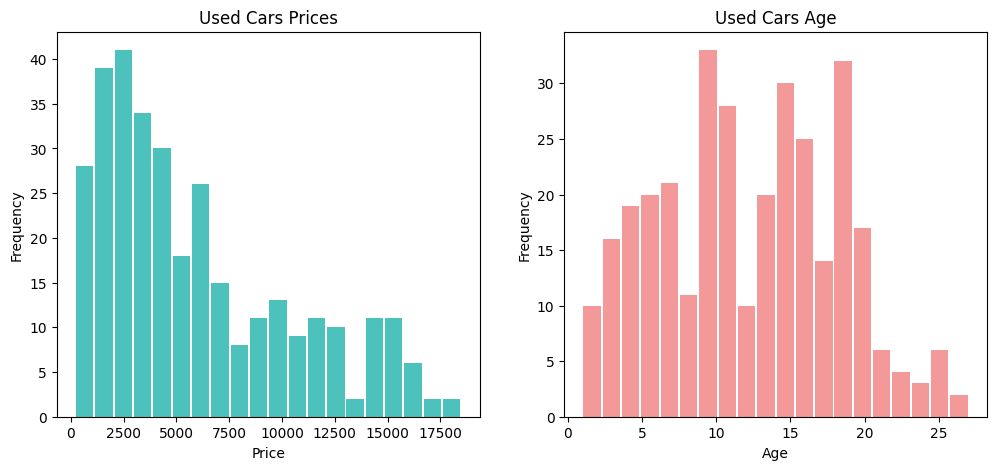

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].hist(df_chicago.price, bins = 20, rwidth=0.9, color = "lightseagreen", alpha = 0.8)

ax[0].set_title("Used Cars Prices")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")


ax[1].hist(df_chicago.age, bins =20, rwidth = 0.9, color = "lightcoral", alpha = 0.8)
ax[1].set_title("Used Cars Age")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Frequency")

##### Scatter plots

The simplest way to see the correlation between two variables is creating scatter plot. From the scatter plot, we can observe that there is a strong correlation between the two variables. Additionally, condition of the car is represented by different markers in the scatter plot to examine variation by condition. However, the graph indicates no significant differences based on condtion. Instead, the prices of cars within the same condition show substantial variation by age, indicating shows age is a strong predictor of car prices.  

Text(48.900489583333325, 0.5, 'Price (US dollars)')

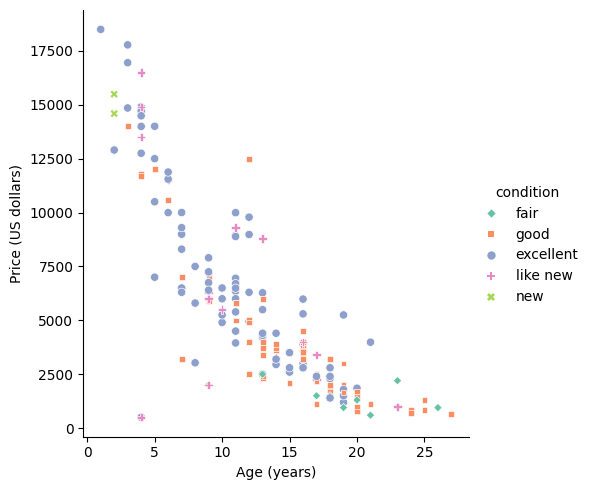

In [14]:
hue_colors = sns.color_palette("Set2")
sns.relplot(x = "age", y="price"
            ,kind = "scatter"
            ,data= df_chicago
            ,hue ="condition"
            ,hue_order=["fair", "good", "excellent", "like new", "new"]
            ,palette = hue_colors
            ,style="condition")
plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")

Linear vs non-linear regression

As shown in the graph, the correlation between price and age is non-linear, suggesting that models such as Log-Level, Polynomial, or Spline regression are better suited to capture the relationship effectively.

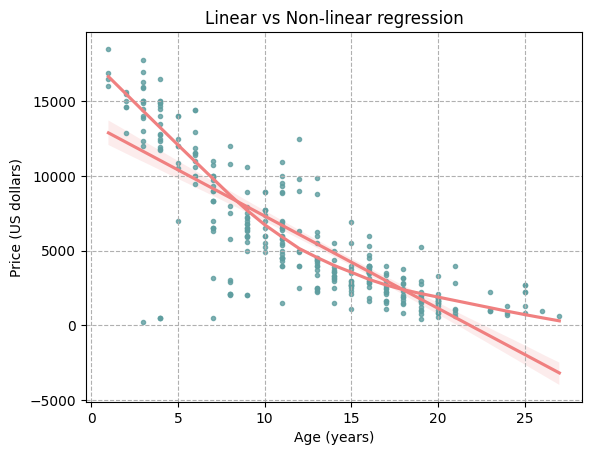

In [15]:
fig, axes = plt.subplots(1, 1)

sns.regplot(x="age", y="price", data=df_chicago
            ,fit_reg = True
            ,lowess=False
            ,scatter=True
            ,ci = 95
            ,marker="."
            ,scatter_kws={"color":"white"}
            ,line_kws={"color":"lightcoral"})

sns.regplot(x="age", y="price", data=df_chicago
            ,fit_reg = True
            ,lowess=True
            ,scatter=True
            ,ci = 95
            ,marker="."
            ,scatter_kws={"color":"cadetblue"}
            ,line_kws={"color":"lightcoral"})

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.title("Linear vs Non-linear regression")
plt.grid(linestyle = '--')

##### Categorical estimation

The simplest regression analysis is the comparison of the average of price across different age categories. Age is divided into 5 groups: less than 6, 6 to 12, 12-18, 18-24, 24+. As shown in the table below, as age increases, the price generally tends to get lower. 

In [16]:
df_chicago["age1"] = (
    + np.where(df_chicago["age"] >= 6, 1, 0)
    + np.where(df_chicago["age"] >= 12, 1, 0)
    + np.where(df_chicago["age"] >= 18, 1, 0)
    + np.where(df_chicago["age"] >= 24, 1, 0)
)

In [17]:
df_chicago.groupby("age1")["price"].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
age1,,,,,,,,
0,53.0,13052.5,4155.7,206.0,12322.0,14000.0,14995.0,18495.0
1,105.0,7220.4,2856.0,500.0,5577.0,6900.0,9300.0,14388.0
2,99.0,3809.3,1878.2,1099.0,2600.0,3500.0,4350.0,12500.0
3,59.0,1815.3,926.5,450.0,1050.0,1650.0,2150.0,5249.0
4,11.0,1490.9,803.1,650.0,850.0,1300.0,2200.0,2700.0


### <span style="color:blue"><b>2. Regression analysis</b></span>

##### 2.1. Level-Level regression

Based on the level-level regression result, the price of car is lower, on average, by $617 for each additional year of age. About 66.6% of the variability in car prices is explained by the model. This indicates a reasonably strong fit for a single-variable model.

In [18]:
reg1 = smf.ols("price ~ age", data = df_chicago).fit(cov_type="HC1")
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     439.6
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           2.44e-62
Time:                        11:36:19   Log-Likelihood:                -3036.4
No. Observations:                 327   AIC:                             6077.
Df Residuals:                     325   BIC:                             6084.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.35e+04    452.143     29.848      0.0

In [19]:
df_summary_reg1 = reg1.get_prediction().summary_frame()

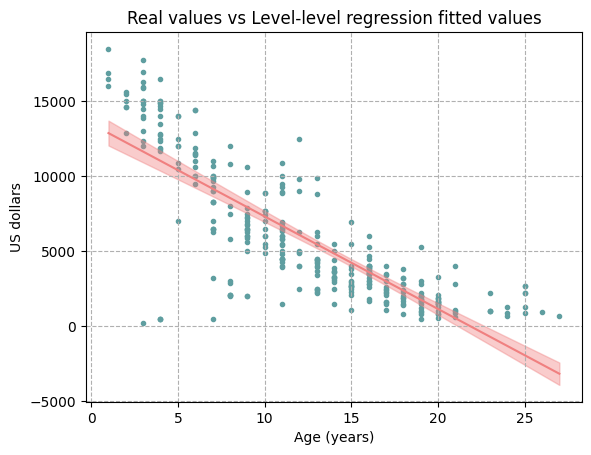

In [20]:
fig, ax = plt.subplots()
ax.scatter(df_chicago.age, df_chicago.price, marker=".", color = "cadetblue")
ax.plot(df_chicago.age, df_summary_reg1["mean"], color="lightcoral")
ax.fill_between(df_chicago.age, df_summary_reg1.mean_ci_lower, df_summary_reg1.mean_ci_upper, color="lightcoral", alpha =0.4)
plt.xlabel("Age (years)")
plt.ylabel("US dollars")
plt.title("Real values vs Level-level regression fitted values")
plt.grid(linestyle = '--')

#### 2.2. Log-Level regression

Based on on log level regression result, On average, the price is 11.5% lower for each additional year of age. While the R-square is not as high as in the Level-Level model, it is still reasonably strong for a single-variable regression.

In [21]:
reg2 = smf.ols("lprice ~ age", data = df_chicago).fit(cov_type="HC1")
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     305.8
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           1.01e-48
Time:                        11:36:19   Log-Likelihood:                -283.36
No. Observations:                 327   AIC:                             570.7
Df Residuals:                     325   BIC:                             578.3
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7203      0.096    101.764      0.0

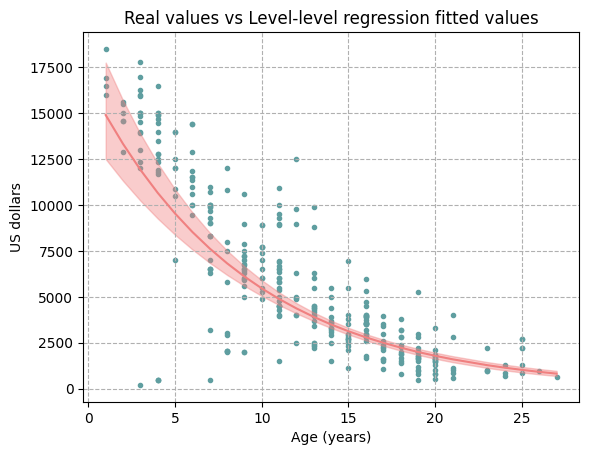

In [22]:
df_summary_reg2 = np.exp(reg2.get_prediction().summary_frame())

fig, ax = plt.subplots()
ax.scatter(df_chicago.age, df_chicago.price, marker=".", color = "cadetblue")
ax.plot(df_chicago.age, df_summary_reg2["mean"], color="lightcoral")
ax.fill_between(df_chicago.age, df_summary_reg2.mean_ci_lower, df_summary_reg2.mean_ci_upper, color="lightcoral", alpha =0.4)
plt.xlabel("Age (years)")
plt.ylabel("US dollars")
plt.title("Real values vs Level-level regression fitted values")
plt.grid(linestyle = '--')

#### 2.3. Log-Log regression

The Log-Log regression gives us the following result: On average, the price is lower by 0.95% correspondence to 1% higher age. 

In [23]:
reg3 = smf.ols("lprice ~ lage", data = df_chicago).fit(cov_type="HC1")
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     191.3
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           1.57e-34
Time:                        11:36:20   Log-Likelihood:                -310.84
No. Observations:                 327   AIC:                             625.7
Df Residuals:                     325   BIC:                             633.3
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5878      0.177     59.661      0.0

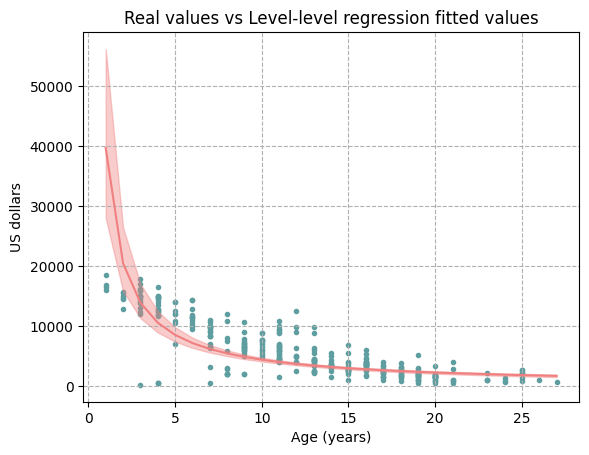

In [24]:
df_summary_reg3 = np.exp(reg3.get_prediction().summary_frame())

fig, ax = plt.subplots()
ax.scatter(df_chicago.age, df_chicago.price, marker=".", color = "cadetblue")
ax.plot(df_chicago.age, df_summary_reg3["mean"], color="lightcoral")
ax.fill_between(df_chicago.age, df_summary_reg3.mean_ci_lower, df_summary_reg3.mean_ci_upper, color="lightcoral", alpha =0.4)
plt.xlabel("Age (years)")
plt.ylabel("US dollars")
plt.title("Real values vs Level-level regression fitted values")
plt.grid(linestyle = '--')

##### 2.4. Polynomial regression

The age coefficient indicates that 1 year higher in age is associated with and average 13.13% lower price. The coefficient of age squared is not statistically significant, meaning there is no polynomial correlation between the two variables.

In [25]:
reg4 = smf.ols("lnprice ~ age + agesq", data = df_chicago).fit(cov_type="HC1")
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     166.1
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           2.25e-50
Time:                        11:36:20   Log-Likelihood:                -283.14
No. Observations:                 327   AIC:                             572.3
Df Residuals:                     324   BIC:                             583.6
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5108      0.349     27.215      0.0

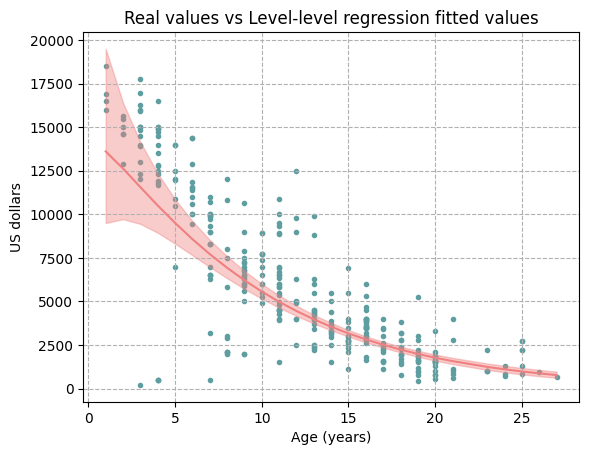

In [26]:
df_summary_reg4 = np.exp(reg4.get_prediction().summary_frame())

fig, ax = plt.subplots()
ax.scatter(df_chicago.age, df_chicago.price, marker=".", color = "cadetblue")
ax.plot(df_chicago.age, df_summary_reg4["mean"], color="lightcoral")
ax.fill_between(df_chicago.age, df_summary_reg4.mean_ci_lower, df_summary_reg4.mean_ci_upper, color="lightcoral", alpha =0.4)
plt.xlabel("Age (years)")
plt.ylabel("US dollars")
plt.title("Real values vs Level-level regression fitted values")
plt.grid(linestyle = '--')

##### 2.5. Piecewise linear spline

Based on piecewise linear spline regression result, For cars younger than 8 years, each additional year is associated with a 10.22% lower, on average. For cars aged 8-16 years, each additional year correspondence to a 10.96% lower, on average. For cars older than 16 years, each additional year correspondence to a 12.33% lower price, on average. This result represents that the negative effect of aging gets higher as age of cars increase.

In [27]:
import copy
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

In [28]:
reg5 = smf.ols(formula="lprice~lspline(age,[8, 16])", data=df_chicago).fit(cov_type="HC1")
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     117.2
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           2.28e-51
Time:                        11:36:20   Log-Likelihood:                -283.02
No. Observations:                 327   AIC:                             574.0
Df Residuals:                     323   BIC:                             589.2
Df Model:                           3                                         
Covariance Type:                  HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.6574      0.202     47.908      0.000       9.262      10.053
lspline(age, [8, 16])[0]    -0.1022      0.029     -3.567      0.000      -0.158      -0.046
lspline(age, [8, 16])[1]    -0.1096      0.012     -8.990      0.000      -0.133      -0.086
lspline(age, [8, 16])[2]    -0.1233      0.016     -7.484      0.000      -0.156      -0.091
==============================================================================
Omnibus:                      238.211   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3199.536
Skew:                          -2.916   Prob(JB):                         0.00
Kurtosis:                      17.171   Cond. No.                         40.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

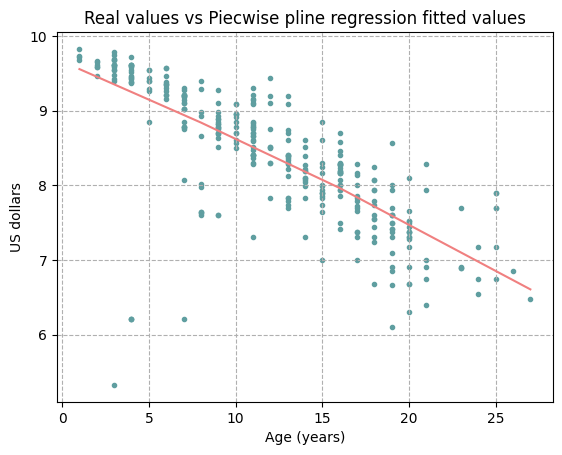

In [29]:
y_hat_spline = reg5.predict()

fig, ax = plt.subplots()
ax.scatter(df_chicago.age, df_chicago.lprice, marker=".", color = "cadetblue")
ax.plot(df_chicago.age, y_hat_spline, color="lightcoral")
plt.xlabel("Age (years)")
plt.ylabel("US dollars")
plt.title("Real values vs Piecwise pline regression fitted values")
plt.grid(linestyle = '--')

##### Comparing regression models

Among all the models, Level-level model has the highest R square. However, interpreting price levels does not provide valuable insights into car pricing. For the Log-Log model, while it captures elasticity, its R square is the lowest, and percentage changes in age may not be ideal in this context.For polimonial model, age squared is not significant, indicating there is no quadratic correlation between two variable. For spline model, it gives us more flexible result and its R square is as high as Log-Level model. However, there is no significant difference among three age-related coefficients. 

Considering interpretability, simplicity, and the percentage changes in price, the Log-Level model is chosen as the best models. 

In [30]:
table = Stargazer([reg1, reg2, reg3, reg4, reg5])
table.rename_covariates({"Intercept": "Constant",
                         "agesq" : "age squared",
                         "lage" : "log(age)",
                         "lspline(age, [8, 16])[0]": "age spline < 8" ,
                         "lspline(age, [8, 16])[1]" : "age spline 8-16",
                         "lspline(age, [8, 16])[2]" : "age spline > 16"})
table.custom_columns(["Level-Level", "Log-Level", "Log-Log", "Polinomial", "Spline"], [1, 1, 1, 1, 1])
table

### <span style="color:blue"><b>3. External validity</b></span>

In [31]:
df_langels

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,year,age,lnodometer,LE,XLE,SE,Hybrid,lprice,lage,agesq
432,$18500,los angeles,LA westside-southbay,2017 toyota camry se,like new,4 cylinders,fwd,gas,0.500000,grey,...,2017,1,-0.693147,0,0,1,0,9.825526,0.000000,1.000000
515,$17000,los angeles,central LA,2017 toyota camry,like new,4 cylinders,fwd,gas,2.000000,black,...,2017,1,0.693147,0,0,0,0,9.740969,0.000000,1.000000
542,$361,los angeles,LA westside-southbay,2017 toyota camry hybrid,new,4 cylinders,rwd,hybrid,0.070000,red,...,2017,1,-2.659260,0,0,0,1,5.888878,0.000000,1.000000
373,$12700,los angeles,LA long beach,2016 toyota camry,NaN,NaN,NaN,gas,4.249044,NaN,...,2016,2,1.446694,0,0,0,0,9.449357,0.693147,1.414214
528,$14995,los angeles,LA westside-southbay,2016 TOYOTA CAMRY SE,good,4 cylinders,fwd,gas,6.546700,white,...,2016,2,1.878961,0,0,1,0,9.615472,0.693147,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,$550,los angeles,LA san gabriel,1993 toyota camry,NaN,NaN,NaN,gas,31.950000,NaN,...,1993,25,3.464172,0,0,0,0,6.309918,3.218876,5.000000
437,$950,los angeles,central LA,1993 toyota camry,NaN,NaN,NaN,gas,21.916666,NaN,...,1993,25,3.087247,0,0,0,0,6.856462,3.218876,5.000000
518,$1500,los angeles,San Fernando,1992 Toyota Camry,good,4 cylinders,fwd,gas,16.800000,grey,...,1992,26,2.821379,0,0,0,0,7.313220,3.258097,5.099020
465,$500,los angeles,LA san gabriel,1991 Toyota Camry,fair,4 cylinders,fwd,gas,21.700000,white,...,1991,27,3.077312,0,0,0,0,6.214608,3.295837,5.196152


#### Log-level regerssion for Los Angeles

In [36]:
reg6 = smf.ols("lprice ~ age", data = df_langels).fit(cov_type="HC1")
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     134.4
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           1.43e-24
Time:                        11:41:34   Log-Likelihood:                -313.17
No. Observations:                 222   AIC:                             630.3
Df Residuals:                     220   BIC:                             637.1
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5817      0.129     74.094      0.000       9.328       9.835
age           -0.1128      0.010    -11.595      0.000      -0.132      -0.094
==============================================================================
Omnibus:                      264.872   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13406.874
Skew:                          -4.972   Prob(JB):                         0.00
Kurtosis:                      39.749   Cond. No.                         31.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In both cities, the intercepts and age coefficients (-0.112 for Chicago, -0.113 for Los Angeles) are similar in magnitude and higly significant. This consistancy supports the external validity of the Chicago model when applied to Los Angeles. 

However, R square is much lower in Los angeles, indicating there are other factors significantly influence car prices there.

In [35]:
table = Stargazer([reg2, reg6])
table.custom_columns(["Chicago", "Los Angeles"], [1, 1])
table